# Layer Normalization

Implementation of the Layer normalization layer.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
from sklearn.decomposition import PCA
import torch
from torch import nn
from torch.nn import functional as F
from torchviz import make_dot
from typing import List, Callable, Dict, Any, Union, Optional, Tuple, Generator
%matplotlib inline

/opt/homebrew/Caskroom/miniconda/base/envs/research/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Approach is as follows:
1. Load a dataset for training (e.g. classification) where we can build a deep network (say ResNet Like)
2. Train a basic version of that network (create a test harness that logs the loss, accuracy & training time)
3. Train a version with batch normalization
4. Implement custom Layer normalization and Test transformation against PyTorch Version
5. Train a version with Layer normalization
6. Plot the results against each other (loss, accuracy & training time)


**Loading a Dataset**

In [66]:
torch_device = torch.device("mps" if torch.has_mps else ("cuda" if torch.cuda.is_available() else "cpu"))
print(f"Using device: {torch_device}")

# read the tiny shakespear dataset
with open('data/tiny_shakespeare.txt', 'r') as f:
    lines = f.read()

# read some stats
print(f"Number of characters: {len(lines)}")
chars = sorted(list(set(lines)))
print(f"Number of unique characters: {len(chars)}")
print(f"Characters: {chars}")

# build a dict
char2idx = {ch: i for i, ch in enumerate(chars)}
idx2char = {i: ch for i, ch in enumerate(chars)}
def encode_tensor(text: str) -> torch.Tensor:
    return torch.tensor([char2idx[ch] for ch in text])

def encode(text: str) -> List[int]:
    return [char2idx[ch] for ch in text]

def decode_tensor(encoded: torch.Tensor) -> str:
    # assert dim
    encoded = encoded.squeeze()
    if encoded.dim() == 2:
        encoded = encoded.argmax(dim=1)
    if encoded.dim() > 1:
        raise ValueError(f"Expected 1D or 2D tensor, got {encoded.dim()}D tensor")
    return ''.join([idx2char[idx] for idx in encoded.tolist()])

def decode(encoded: List[int]) -> str:
    return ''.join([idx2char[idx] for idx in encoded])

assert decode(encode("hello world")) == "hello world"
assert decode_tensor(encode_tensor("hello world")) == "hello world"

# encode the tensor
data = encode_tensor(lines)

# split the data
split_idx = int(len(data) * 0.9)
train_data = data[:split_idx]
test_data = data[split_idx:]

print(f"Train data: {train_data.shape[0]:08}")
print(f"Test data:  {test_data.shape[0]:08}")

# build a batch generator - this should sample random section from the text
def random_batch(data: torch.Tensor, block_size: int, batch_size: int) -> Tuple[torch.Tensor, torch.Tensor]:
    '''Retrieves a random batch from the provided data'''
    # check the input data
    if data.dim() != 1:
        raise ValueError(f"Expected 1D tensor, got {data.dim()}D tensor")

    # create a random starting point
    # note: we need to have one last char for output
    # note: also need to have block_size difference
    start_idx = torch.randint(0, len(data) - block_size - 1, (batch_size,))

    # retrieve the content length (batchsi)
    content = torch.stack([data[i:i + block_size + 1] for i in start_idx])
    x = content[:, :-1]
    y = content[:, 1:]
    return x, y

# generate a random batch
x, y = random_batch(train_data, 10, 5)
x.shape

Using device: mps
Number of characters: 1115394
Number of unique characters: 65
Characters: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Train data: 01003854
Test data:  00111540


torch.Size([5, 10])

**Baseline Model**

Create a baseline model that allows injection of normalization layers.

In [71]:
block_size = 32
vocab_size = len(chars)

# create an attention head module
class AttentionHead(nn.Module):
    def __init__(self, emb_size: int, head_size: int, encoder: bool, block_size: int = 32):
        super().__init__()

        # create params
        self.encoder = encoder
        self.head_size = head_size
        self.emb_size = emb_size
        self.k = nn.Linear(emb_size, head_size)
        self.q = nn.Linear(emb_size, head_size)
        self.v = nn.Linear(emb_size, head_size)

        # create register buffer for the tril
        self.register_buffer("tril", torch.tril(torch.ones((block_size, block_size), dtype=torch.float32)))
    
    def forward(self, x):
        # compute key and query vectors
        xk = self.k(x)  # (B, T, H)
        xq = self.q(x)  # (B, T, H)

        # compute weight by transpose and matmul product
        wei = xq @ xk.transpose(-1, -2)
        if self.encoder:
            wei = wei.masked_fill(self.tril == 0, float('-inf'))
        
        # normalize weights and apply to value transform
        wei = F.softmax(wei / self.head_size**-.5, dim=-1)
        return wei @ self.v(x)  # (B, T, H)


class MultiAttentionHead(nn.Module):
    def __init__(self, num_heads: int, emb_size: int, head_size: int, block_size: int, encoders: bool) -> None:
        super().__init__()

        self.heads = nn.ModuleList([AttentionHead(emb_size, head_size, block_size=block_size, encoder=encoders) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, emb_size)
    
    def forward(self, x):
        # compute the attention for each head
        outs = [head(x) for head in self.heads]
        out = self.proj(torch.cat(outs, dim=-1))
        return out

class TransformerBlock(nn.Module):
    def __init__(self, norm: Callable[[int], nn.Module], emb_size: int, num_heads: int, encoders: bool, block_size: int, head_size: int = None, proj_size: int = None):
        super().__init__()

        # compute the headsize for each head
        head_size = head_size or (emb_size // num_heads)
        proj_size = proj_size or (head_size * num_heads * 4)

        # mutli-head attention
        self.att_head = MultiAttentionHead(num_heads, emb_size, head_size, block_size=block_size, encoders=encoders)

        # compute the relu layer
        self.relu_layer = nn.Sequential(
            nn.Linear(head_size * num_heads, proj_size),
            nn.ReLU(),
            nn.Linear(proj_size, emb_size),
        )

        # normalization
        self.norm1 = norm(emb_size)
        self.norm2 = norm(emb_size)
    
    def forward(self, x):
        print(x.shape)
        out = self.att_head(self.norm1(x)) + x
        out = self.relu_layer(self.norm2(out)) + out
        return out

class TfModel(nn.Module):
    def __init__(self, vocab_size: int, norm: Callable[[int], nn.Module] = None, emb_size: int = 128, num_layers: int = 10):
        super().__init__()
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.pos_embedding = nn.Embedding(vocab_size, emb_size)
        self.norm_fct = norm or (lambda x: nn.Identity())

        # generate the transformer blocks
        self.blocks = nn.ModuleList([TransformerBlock(self.norm_fct, emb_size, num_heads=8, block_size=block_size, encoders=True) for _ in range(num_layers)])
        self.norm = self.norm_fct(emb_size)
        self.fc = nn.Linear(emb_size, vocab_size)
    
    @property
    def device(self):
        return next(self.parameters()).device
    
    @property
    def param_count(self) -> int:
        return sum([p.numel() for p in self.parameters()])
    
    def forward(self, x):
        # validate device
        if self.device != x.device:
            x = x.to(self.device)

        # retrieve the embeddings
        embs = self.embedding(x) + self.pos_embedding(torch.arange(block_size, device=x.device))

        # compute attention
        att = embs
        for blck in self.blocks:
            att = blck(att)
        att = self.norm(att)

        # compute logits
        return self.fc(att)

# create the model and test
model = TfModel(vocab_size, norm=None)
model.to(torch_device)
print(f"Model has {model.param_count} parameters")

# test the model
bx, by = random_batch(train_data, block_size, 5)
out = model(bx)
out.shape

Model has 2002625 parameters


torch.Size([5, 32, 65])

**Test Harness**

Create a harness function to execute one epoch of train and testing in the entire dataset as well as a fucntion that executes a train regimen on the entire data.

In [77]:
from time import time

def train_step(model: TfModel, opt: torch.optim.Optimizer, batch_size: int = 10) -> dict:
    start = time()
    bx, by = random_batch(train_data, block_size, batch_size)
    if torch_device != bx.device:
        bx = bx.to(torch_device)
        by = by.to(torch_device)
    batch_time = time()
    out = model(bx)
    loss = F.cross_entropy(out.view(-1, model.vocab_size), by.reshape(-1))
    loss.backward()
    train_time = time()
    opt.step()
    opt.zero_grad()
    opt_time = time()

    return {
        'batch_time': batch_time - start,
        'train_time': train_time - batch_time,
        'opt_time': opt_time - train_time,
        'total_time': opt_time - start,
        'loss': loss.detach().cpu().item(),
    }

def test_epoch(model: TfModel, batch_size: int = 10):
    # set model to eval
    model.eval()

    # iterate through steps
    loss = []
    start = time()
    for _ in range(0, len(test_data), batch_size):
        bx, by = random_batch(test_data, block_size, batch_size)
        if torch_device != bx.device:
            bx = bx.to(torch_device)
            by = by.to(torch_device)
        out = model(bx)
        loss.append(F.cross_entropy(out.view(-1, model.vocab_size), by.reshape(-1)).detach().cpu().item())

    return {
        'loss': np.mean(loss),
        'time': time() - start,
    }

def train(model, epochs: int=5, steps_per_epoch: int=100, batch_size: int=10, block_size: int=block_size, lr: float=1e-4):
    # create optimizer
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    # opt = torch.optim.SGD(model.parameters(), lr=lr)

    train_stats = []
    test_stats = []

    # iterate through epochs
    for epoch in range(epochs):
        # set model to train
        model.train()

        # iterate through steps
        for step in range(steps_per_epoch):
            stats = train_step(model, opt, batch_size)
            train_stats.append(stats)
            if step % 10 == 0:
                print(f"Step {step} loss: {stats['loss']:.3f} time: {stats['total_time']:.3f}s")
        
        # average the loss
        avg_loss = np.mean([s['loss'] for s in train_stats[-steps_per_epoch:]])
        avg_time = np.mean([s['total_time'] for s in train_stats[-steps_per_epoch:]])
        print(f"Epoch {epoch} Train loss: {avg_loss:.3f} | time: {avg_time:.3f}s")

        # run a test
        stats = test_epoch(model)
        test_stats.append(stats)
        print(f"Epoch {epoch} Test  loss: {stats['loss']:.3f} | time: {stats['total_time']:.3f}s")
    
    return train_stats, test_stats

# execute training
base_model = TfModel(vocab_size, norm=None)
base_model.to(torch_device)

# run the test
base_train_stats, base_test_stats = train(base_model)

Step 0 loss: 5.994 time: 0.989s
Step 10 loss: 4.651 time: 0.925s
Step 20 loss: 4.075 time: 0.960s
Step 30 loss: 3.977 time: 0.975s
Step 40 loss: 4.082 time: 0.997s
Step 50 loss: 3.874 time: 1.080s
Step 60 loss: 3.577 time: 0.976s
Step 70 loss: 3.650 time: 0.931s
Step 80 loss: 3.413 time: 0.998s
Step 90 loss: 3.697 time: 1.022s
Epoch 0 Train loss: 4.018 | time: 0.983s


KeyboardInterrupt: 

**Train Batch Normalization**

In [ ]:
bn = lambda x: nn.BatchNorm1d(x, affine=False)

bn_model = TfModel(bn)
bn_model.to(torch_device)
print(f"Model has {bn_model.param_count} parameters")
bn_train_stats, bn_test_stats = train(base_model)

**Implement Layer Normalization**

Create a custom module for layer normalization and compare it to torch internal one.

In [65]:
class LayerNorm(nn.Module):
    def __init__(self, num_features: int, eps: float = 1e-5):
        super().__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(num_features))  # [C]
        self.beta = nn.Parameter(torch.zeros(num_features))  # [C]

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # input: [B, C]
        # compute the mean and variance for the current layer
        mean = x.mean(dim=-1, keepdim=True)  # [B, 1]
        var = x.var(dim=-1, keepdim=True, unbiased=False)   # [B, 1]

        # apply the normalization
        out = (x - mean)
        out = out / torch.sqrt(var + self.eps)
        out = out * self.gamma
        out = out + self.beta
        return out

rand = torch.randn(100, 10) * 10 + 5
custom_ln = LayerNorm(10)
torch_ln = nn.LayerNorm(10)

out_custom = custom_ln(rand)
out_torch = torch_ln(rand)

close = torch.allclose(out_custom, out_torch)
diff = torch.abs(out_custom - out_torch).sum()
print(f"Close: {close}, Diff: {diff}")
print(f"Torch Var:  {torch.var(out_torch, dim=0).mean():30}, Custom Var:  {torch.var(out_custom, dim=0).mean()}")
print(f"Torch Mean: {torch.mean(out_torch, dim=0).mean():30}, Custom Mean: {torch.mean(out_custom, dim=0).mean()}")

Close: False, Diff: 7.069925777614117e-05
Torch Var:              1.0009536743164062, Custom Var:  1.0009536743164062
Torch Mean:         1.0430812658057675e-08, Custom Mean: 2.9802322831784522e-09


Next Train a model

In [ ]:
ln = lambda x: LayerNorm(x, affine=False)

ln_model = TfModel(ln)
ln_model.to(torch_device)
print(f"Model has {ln_model.param_count} parameters")
ln_train_stats, ln_test_stats = train(ln_model)

# TODO: visualize the gain and bias modification over time?

Plot Results in different graphs

In [14]:
# TODO: generate subgraphs

In [86]:
# load all the data from json
import json
import os

base_data = os.path.join('stats', 'base_stats.json')
with open(base_data, 'r') as f:
    base_stats = json.load(f)

bn_data = os.path.join('stats', 'bn_stats.json')
with open(bn_data, 'r') as f:
    bn_stats = json.load(f)

ln_data = os.path.join('stats', 'ln_stats.json')
with open(ln_data, 'r') as f:
    ln_stats = json.load(f)

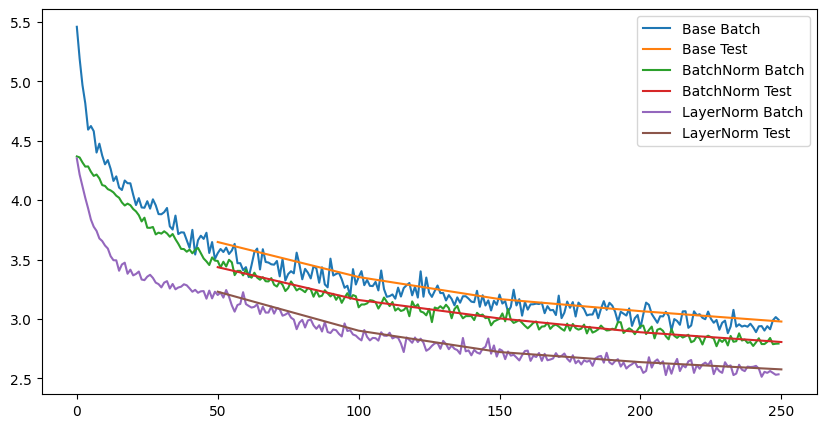

In [94]:
# print the train and validation losses over time
epoch_steps = 50

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

# plot the base model
loss = [s['loss'] for s in base_stats['train']]
ax.plot(np.arange(len(loss)), loss, label='Base Batch')
loss = [s['loss'] for s in base_stats['test']]
ax.plot((np.arange(len(loss)) + 1) * epoch_steps, loss, label='Base Test')

loss = [s['loss'] for s in bn_stats['train']]
ax.plot(np.arange(len(loss)), loss, label='BatchNorm Batch')
loss = [s['loss'] for s in bn_stats['test']]
ax.plot((np.arange(len(loss)) + 1) * epoch_steps, loss, label='BatchNorm Test')

loss = [s['loss'] for s in ln_stats['train']]
ax.plot(np.arange(len(loss)), loss, label='LayerNorm Batch')
loss = [s['loss'] for s in ln_stats['test']]
ax.plot((np.arange(len(loss)) + 1) * epoch_steps, loss, label='LayerNorm Test')

ax.legend()
plt.show()